## Example - Xgboost, state-of-the-art ensemble method for structured data

Xgboost is one of the latest implementations of gradient boosting algorithms, with many optimisations compared to other gradient boosting algorithms.  
https://xgboost.readthedocs.io/en/latest/

In this example, we are predicting abnormal Tobin's Q using board characteristics.

### Libraries
*Pandas* and *Numpy* for data processing.  
*Scipy* and *Statsmodels* for statistical analysis.  
*Matplotlib* for plotting.  

In [74]:
import xgboost
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import scipy.stats as ss
import statsmodels.api as sm

In [75]:
plt.xkcd()

A function to check the normality of a dataset. Draws a histogram and a normal curve. It also calculates the Kolmogorov-Smirnov statistic of the dataset.

In [76]:
# Function to check normality
def check_normality(data,bins=50):
    mask = ~np.isnan(data)
    temp1 = data[mask]
    x = np.linspace(np.percentile(temp1,1),np.percentile(temp1,99),100)
    plt.hist(temp1, density=True,bins=bins)
    plt.plot(x,ss.norm.pdf(x,np.mean(temp1),np.std(temp1)))
    print("Kolmogorov-Smirnov: " + str(sm.stats.diagnostic.kstest_normal(temp1)))

Data preparation, which includes:  
* Loading data from a csv-file
* Removing missing y-values
* Loading the abnormal Tobin Q values to the y_df dataframe
* Loading the board characteristic variables to the x_df dataframe
* Winsorizing the data, meaning that we transform the most extreme values to the 1 % and 99 % percentile values.

In [77]:
# Prepare data.
errors_df = pd.read_csv("AbnormalQ.csv",delimiter=";")
errors_df = errors_df.rename(columns = {'BOARD_GENDER_DIVERSITY_P' : 'BOARD_GENDER_DIVERSITY','BOARD_MEMBER_COMPENSATIO' : 'BOARD_MEMBER_COMPENSATION'})
# Remove missing abQ values
errors_df = errors_df.loc[~errors_df['ABN_TOBIN_POIKKILEIK'].isna()]
y_df = errors_df['ABN_TOBIN_POIKKILEIK']
x_df = errors_df[['BOARD_GENDER_DIVERSITY',
       'BOARD_MEETING_ATTENDANCE', 'BOARD_MEMBER_AFFILIATION',
       'BOARD_MEMBER_COMPENSATION', 'BOARD_SIZE',
       'CEO_BOARD_MEMBER', 'CHAIRMAN_IS_EX_CEO',
       'INDEPENDENT_BOARD_MEMBER',
       'NUMBER_OF_BOARD_MEETINGS',
       'AVERAGE_BOARD_TENURE']]
# Winsorize x-data
x_df_wins = x_df.clip(lower=x_df.quantile(0.01), upper=x_df.quantile(0.99), axis = 1)

Calculate the descriptive statistics of the x variables (board characteristics).

In [78]:
x_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BOARD_GENDER_DIVERSITY,3856.0,1.790492e+01,1.065878e+01,0.00,11.11,18.18,25.00,7.500000e+01
BOARD_MEETING_ATTENDANCE,3691.0,7.892493e+01,8.829494e+00,5.00,75.00,75.00,75.00,1.000000e+02
BOARD_MEMBER_AFFILIATION,3856.0,1.001004e+00,6.346233e-01,0.00,0.58,0.92,1.33,8.890000e+00
BOARD_MEMBER_COMPENSATION,3799.0,2.942600e+06,3.141424e+07,388.00,1570763.00,2093063.00,2788399.50,1.929824e+09
BOARD_SIZE,3856.0,9.919865e+00,2.095281e+00,1.00,9.00,10.00,11.00,1.700000e+01
CEO_BOARD_MEMBER,3838.0,9.838458e-01,1.260850e-01,0.00,1.00,1.00,1.00,1.000000e+00
CHAIRMAN_IS_EX_CEO,3857.0,6.238009e-01,4.844938e-01,0.00,0.00,1.00,1.00,1.000000e+00
INDEPENDENT_BOARD_MEMBER,3850.0,8.219792e+01,9.624940e+00,33.33,77.78,84.62,90.00,1.000000e+02
NUMBER_OF_BOARD_MEETINGS,3767.0,7.920361e+00,3.544352e+00,1.00,6.00,7.00,9.00,4.300000e+01
AVERAGE_BOARD_TENURE,3814.0,9.598506e+00,3.673708e+00,0.07,7.23,9.15,11.58,2.886000e+01


An example of the check_normality -function.

Kolmogorov-Smirnov: (0.04520799160648903, 0.0009999999999998899)


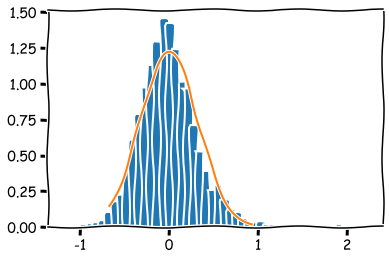

In [79]:
check_normality(y_df)

Convert the data to a xgboost dmatrix, that is more computationally efficient form for data.

In [80]:
dtrain = xgboost.DMatrix(x_df_wins, label=y_df, nthread = -1)

***
The most difficult part in using xgboost for prediction is the tuning of hyperparameters. There is no good theory to guide parameter optimisation, and it is more dark magic than science. You can use grid-search approaches, but it needs A LOT of computing power. The parameters that we fine-tune are:  
* num_boost_round: The number of decision trees.
* max_depth: The depth of the trees.
* eta: The weight of the added tree
* subsample: A randomly selected subsample of the data, that is used at each round.
* colsample_bytree: A randomly selected subsample of features, that is used for each tree (this can be done also by node and by level).
* min_child_weight: A regularisation parameter. In the linear regression case this would mean the minimum number of data points that needs to be in the leaves
* gamma: A regularisation parameter, that controls the loss function.

There are many other tunable parameters in the model, but we leave them to default values.

In [81]:
m_depth = 5
eta = 0.02
ssample = 0.8
col_tree = 0.8
m_child_w = 1
gam = 0.1
param = {'max_depth': m_depth, 'eta': eta, 'subsample': ssample, 'colsample_bytree': col_tree, 'min_child_weight' : m_child_w, 'gamma' : gam}

Xgboost.cv -function can be used to search the optimal number of trees in the model. We search the number of trees that achieve the lowest *root-mean-square-error*. In this case, the optimal number of trees appears to be around 600.

In [82]:
temp = xgboost.cv(param,dtrain,num_boost_round=900,nfold=5,seed=10)

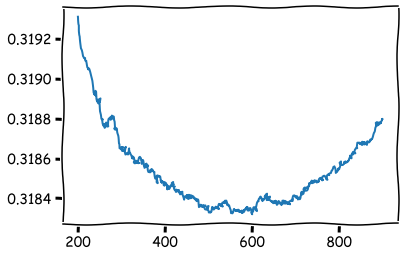

In [83]:
plt.plot(temp['test-rmse-mean'][200:900])
plt.show()

In [84]:
b_rounds = 600

The model is trained using the *train*-function. The number of trees was set to 600 based on the cross-validation results.

In [85]:
bst = xgboost.train(param,dtrain,num_boost_round=b_rounds)

***
In the following we analyse the results of the model using the methods of explainable AI.

Histrogram for the split points in the threes for the variable *Board gender diversity*. Notice that this information cannot be used for deciding what is the optimal percentage. The model just tries to separate companies according to their market performance. This is not necessarily achieved by separating data using the "optimal" feature values.

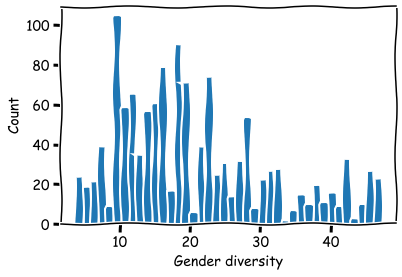

In [86]:
# Histogram of split points
split_bars = bst.get_split_value_histogram(feature='BOARD_GENDER_DIVERSITY',bins = 40)
plt.bar(split_bars['SplitValue'],split_bars['Count'])
plt.xlabel('Gender diversity')
plt.ylabel('Count')
plt.show()

***
Average of the split points.

In [87]:
aver_split_points = []
for feat in bst.feature_names:
    split_bars = bst.get_split_value_histogram(feature=feat,as_pandas=False)
    temp = sum(split_bars[:,0]*split_bars[:,1])/(sum(split_bars[:,1]))
    aver_split_points.append(temp)
aver_df = pd.DataFrame()
aver_df['averages'] = aver_split_points
aver_df.index = bst.feature_names
aver_df.round(2)

,averages
BOARD_GENDER_DIVERSITY,20.40
BOARD_MEETING_ATTENDANCE,102.42
BOARD_MEMBER_AFFILIATION,0.98
BOARD_MEMBER_COMPENSATION,2289342.12
BOARD_SIZE,9.28
CEO_BOARD_MEMBER,1.28
CHAIRMAN_IS_EX_CEO,1.00
INDEPENDENT_BOARD_MEMBER,77.93
NUMBER_OF_BOARD_MEETINGS,10.33
AVERAGE_BOARD_TENURE,9.58


Basic metrics that can be used to measure the feature importance are *weight,gain* and *cover*. There are many issues with these metrics. For example the weight metric undervalues binary features. Below is their explanation from the xgboost documents:
* ‘weight’: the number of times a feature is used to split the data across all trees.
* ‘gain’: the average gain across all splits the feature is used in.
* ‘cover’: the average coverage across all splits the feature is used in.

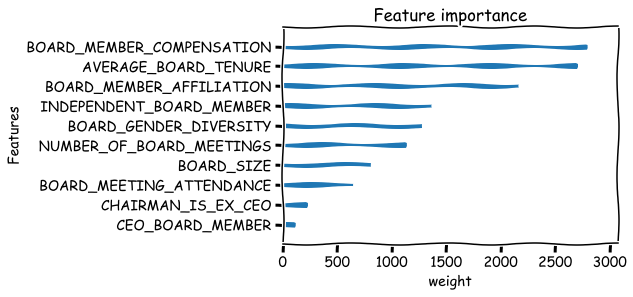

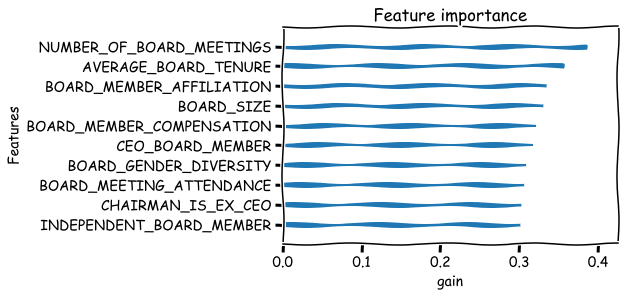

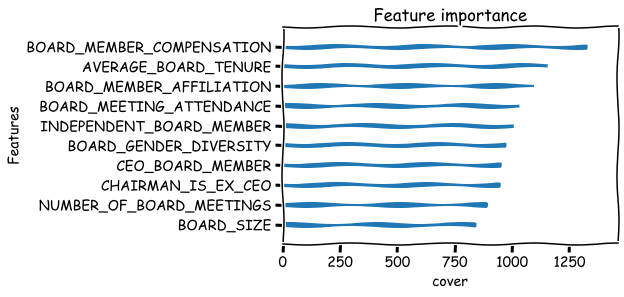

In [88]:
xgboost.plot_importance(bst,importance_type='weight',xlabel='weight',show_values=False,grid=False),
xgboost.plot_importance(bst,importance_type='gain',xlabel='gain',show_values=False,grid=False),
xgboost.plot_importance(bst,importance_type='cover',xlabel='cover',show_values=False,grid=False)
plt.show()

#### SHAP analysis
Because the basic importance metrics have many weaknesses, the machine learning community is doing a lot of research at the moment to invent better ways to analyse machine learning models. One recent innovation is SHAP values. https://github.com/slundberg/shap

In [89]:
j=0
shap.initjs()

Below, shap values are calculated for the model.

In [90]:
explainerXGB = shap.TreeExplainer(bst)
shap_values_XGB = explainerXGB.shap_values(x_df_wins,y_df,check_additivity = False)

A summary plot of the most important features. From the board characteristics the most important explainers of market performance are *Number of board meetings*, *Board member compensation*, *Average board tenure* and *Board member affiliation*. In this example, the meaning of the SHAP values is *the absolute average effect on the abnormal tobin Q of the company*.

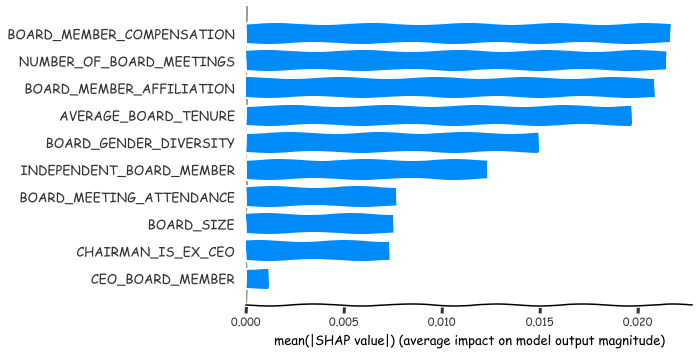

In [91]:
shap.summary_plot(shap_values_XGB,x_df_wins,plot_type='bar')

Present the average values as a dataframe.

In [92]:
shaps = np.mean(abs(shap_values_XGB), axis = 0)
names = bst.feature_names
apu_df = pd.DataFrame()
apu_df['names'] = names
apu_df['shaps'] = shaps
apu_df

,names,shaps
0,BOARD_GENDER_DIVERSITY,0.014892
1,BOARD_MEETING_ATTENDANCE,0.007698
2,BOARD_MEMBER_AFFILIATION,0.020881
3,BOARD_MEMBER_COMPENSATION,0.021699
4,BOARD_SIZE,0.007537
5,CEO_BOARD_MEMBER,0.001149
6,CHAIRMAN_IS_EX_CEO,0.007380
7,INDEPENDENT_BOARD_MEMBER,0.012343
8,NUMBER_OF_BOARD_MEETINGS,0.021496
9,AVERAGE_BOARD_TENURE,0.019675


The above SHAP plot has no information about the nature of association. Is it positive or negative? *Number of board meetings* has the largest effect, but is it increasing or decreasing abnormal Tobin's Q? This is estimated below.

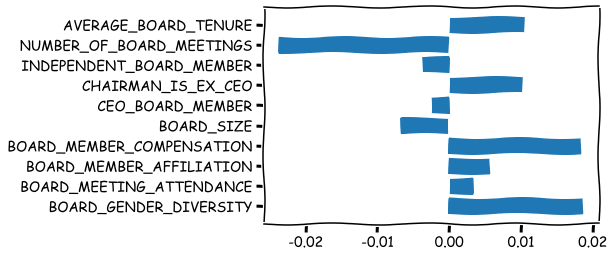

In [93]:
stand_feats = (x_df_wins-x_df_wins.mean(axis = 0))/x_df_wins.std(axis = 0)
std_feat_times_shaps = np.multiply(shap_values_XGB,stand_feats)
dir_metric = np.mean(std_feat_times_shaps, axis = 0)
plt.barh(range(10),dir_metric,tick_label = bst.feature_names)
plt.show()

More detailed analysis of the nature of association can be achieved with the scatter plots of SHAP values.

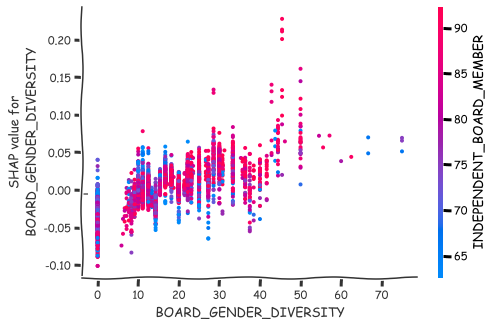

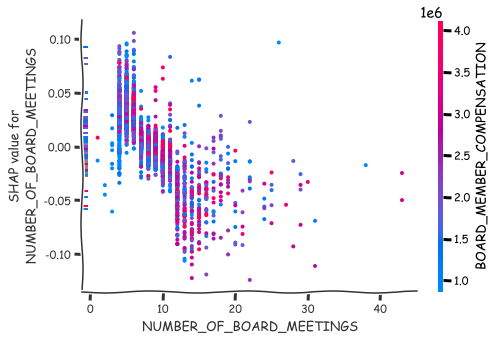

In [94]:
shap.dependence_plot(0,shap_values_XGB,x_df),
shap.dependence_plot(8,shap_values_XGB,x_df)

Scatter plots for all the variables.

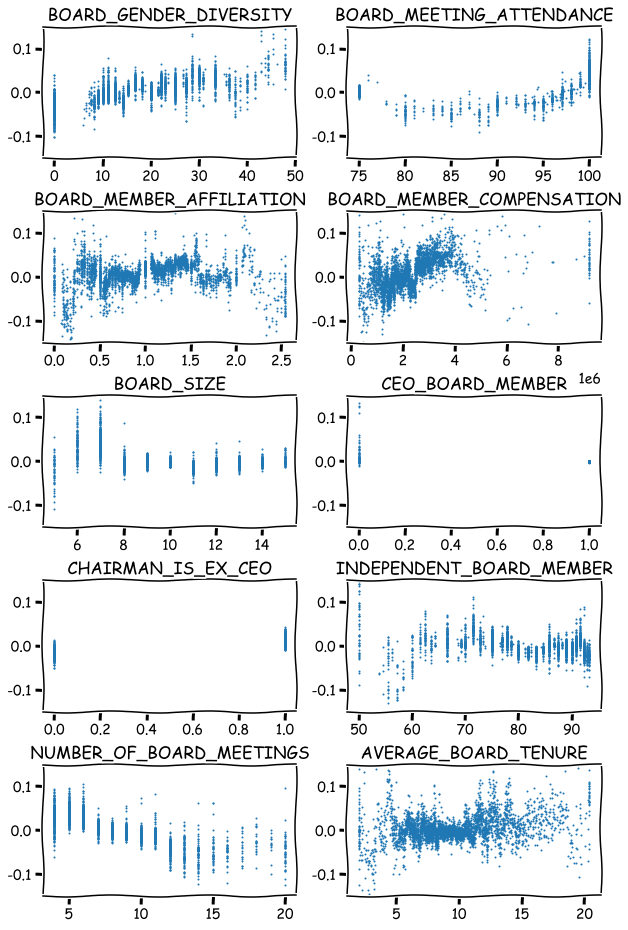

In [95]:
fig, axs = plt.subplots(5,2,figsize=(10,16),squeeze=True)
ind = 0
for ax,feat in zip(axs.flat,x_df_wins.columns):
    ax.scatter(x_df_wins[feat],shap_values_XGB[:,ind],s=1)
    ax.set_ylim([-0.15,0.15])
    ax.set_title(feat)
    ind+=1
plt.subplots_adjust(hspace=0.4)
plt.show()

Below is an analysis where two subgroups are compared to each other. The subgroups are formed using the extreme values of the features.